# Packages

In [1]:
import pandas as pd
import numpy as np
import os
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None) # show full width of showing cols

In [2]:
import mitosheet

# Load Data

In [2]:
# File including all sandwich attacks
dfAttackMaster = pd.read_parquet(f"/Volumes/Extreme SSD/98_Output/AttacksUniswapV2_Master.par")
# File including all relevant gas price data (gas data Barbon + gas data threshold)
dfMaster = pd.read_parquet(f"/Volumes/Extreme SSD/01_GasData/GasPriceAll.par")

# File including with avg gas price and gas_used per block from BQ to calculate GasFee per block
dfGasFeeSum = pd.read_csv(f"/Volumes/Extreme SSD/01_GasData/GasFeePerBlock_BQ_v2.csv")


In [33]:
# not neede anymore
#dfMaster = dfMaster.rename(columns={"trans_gasPrice_Gwei": "threshold_gas"})

In [34]:
dfMaster

,tot_gas,avg_gas,median_gas,tx,ts,block_number_bar,block_number,threshold_gas,total_gasUsed
0,22817345,34.401466,20.000000,92,2020-05-19 00:00:32,10093070,10093070,16.5,9992145
1,37810488,38.025468,20.000000,59,2020-05-19 00:00:59,10093071,10093071,16.5,9988660
2,19912767,66.245960,31.900000,56,2020-05-19 00:01:04,10093072,10093072,6.0,9996320
3,43009981,23.723614,18.000001,93,2020-05-19 00:01:29,10093073,10093073,16.0,9981147
4,26796744,41.613122,20.000000,77,2020-05-19 00:01:37,10093074,10093074,16.0,9977063
...,...,...,...,...,...,...,...,...,...
2346697,42583689,53.583429,46.200000,266,2021-05-24 23:58:42,12500184,12500184,36.3,14994858
2346698,24883565,41.715752,40.000000,213,2021-05-24 23:59:12,12500185,12500185,10.0,14988469
2346699,43760172,50.266184,46.805000,326,2021-05-24 23:59:14,12500186,12500186,6.0,14995703
2346700,54665462,46.356423,44.000000,163,2021-05-24 23:59:41,12500187,12500187,36.0,15003643


# Data Set with total gas fee per block

In [35]:
#Gwei and ETH conversion
dfGasFeeSum = dfGasFeeSum.rename(columns={"total_gasFee": "total_gasFee_Gwei"})
dfGasFeeSum['total_gasFee_ETH'] = dfGasFeeSum['total_gasFee_Gwei']/1000000000



In [36]:
# not needed anymore
#dfGasFeeSum = dfGasFeeSum.sort_values('block_number')
#dfGasFeeSum['avgGasPrice'] = dfGasFeeSum['avgGasPrice']/1000000000
#dfGasFeeSum['total_GasFee'] = dfGasFeeSum['avgGasPrice']*dfGasFeeSum['sumGasUsed']

In [37]:
dfGasFeeSum

,block_number,total_gasFee_Gwei,total_gasFee_ETH
0,12428381,1.613677e+09,1.613677
1,12428752,1.849782e+09,1.849782
2,12423607,2.604481e+09,2.604481
3,12428489,1.519654e+09,1.519654
4,12424706,2.108524e+09,2.108524
...,...,...,...
2348823,10106698,4.325550e+08,0.432555
2348824,10111855,2.608657e+08,0.260866
2348825,10106514,2.608060e+08,0.260806
2348826,10108060,4.435384e+08,0.443538


## Checks of gas data frames

In [38]:
dfMaster.isnull().sum().sum()

0

In [39]:
dfMaster.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2346702 entries, 0 to 2346701
Data columns (total 9 columns):
 #   Column            Dtype         
---  ------            -----         
 0   tot_gas           int64         
 1   avg_gas           float64       
 2   median_gas        float64       
 3   tx                int64         
 4   ts                datetime64[ns]
 5   block_number_bar  int64         
 6   block_number      int64         
 7   threshold_gas     float64       
 8   total_gasUsed     int64         
dtypes: datetime64[ns](1), float64(3), int64(5)
memory usage: 179.0 MB


In [40]:
# Compare block numbering from barbon and Threshold df
dfMaster['Diff'] = np.where( dfMaster['block_number_bar'] == dfMaster['block_number'] , '1', '0')
dfMaster['block_number_bar'].compare(dfMaster['block_number'])
dfMaster['Diff'] = np.where( dfMaster['block_number_bar'] == dfMaster['block_number'] , '1', '0')
print(
    dfMaster['Diff'].nunique(),
    dfMaster['block_number_bar'].compare(dfMaster['block_number'])
)
    
#dfMaster['block_number_bar'].equals(dfMaster['block_number']) # doesnt work becaus of column header

1 Empty DataFrame
Columns: [self, other]
Index: []


In [41]:
# Delete unused columns
dfMaster = dfMaster.drop(['block_number_bar', 'Diff'],axis =1)

In [42]:
# Move block_number to first position
first_column = dfMaster.pop('block_number')
dfMaster.insert(0, 'block_number', first_column)

In [43]:
dfMaster

,block_number,tot_gas,avg_gas,median_gas,tx,ts,threshold_gas,total_gasUsed
0,10093070,22817345,34.401466,20.000000,92,2020-05-19 00:00:32,16.5,9992145
1,10093071,37810488,38.025468,20.000000,59,2020-05-19 00:00:59,16.5,9988660
2,10093072,19912767,66.245960,31.900000,56,2020-05-19 00:01:04,6.0,9996320
3,10093073,43009981,23.723614,18.000001,93,2020-05-19 00:01:29,16.0,9981147
4,10093074,26796744,41.613122,20.000000,77,2020-05-19 00:01:37,16.0,9977063
...,...,...,...,...,...,...,...,...
2346697,12500184,42583689,53.583429,46.200000,266,2021-05-24 23:58:42,36.3,14994858
2346698,12500185,24883565,41.715752,40.000000,213,2021-05-24 23:59:12,10.0,14988469
2346699,12500186,43760172,50.266184,46.805000,326,2021-05-24 23:59:14,6.0,14995703
2346700,12500187,54665462,46.356423,44.000000,163,2021-05-24 23:59:41,36.0,15003643


## Checks for attack dataframe

In [44]:
dfAttackMaster['gasUsed'].isnull().sum()

0

In [45]:
dfAttackMaster['effective_gas_price'].isnull().sum()

0

In [46]:
dfAttackMaster['Attack_UID'].isnull().sum()

0

In [47]:
# Number of transactions which occur in 1+ observations 
len(dfAttackMaster['transaction_hash'])-dfAttackMaster['transaction_hash'].nunique()

20

In [48]:
# Remoev duplicate 'transaction_hash' to avoid double counting
dfAttackMaster = dfAttackMaster.drop_duplicates(subset = ['transaction_hash'], keep=False)

In [49]:
# Number of transactions which occur in 1+ observations after duplicate removal
len(dfAttackMaster['transaction_hash'])-dfAttackMaster['transaction_hash'].nunique()

0

# AttackMaster: proxy contract identification

## Filter for tranactions using Uniswap Routers (both)
* 0xf164fc0ec4e93095b804a4795bbe1e041497b92a version01
* 0x7a250d5630b4cf539739df2c5dacb4c659f2488d version02

In [50]:
list(dfAttackMaster.columns)

['transaction_hash',
 'block_number',
 'transaction_index',
 'log_index',
 'from_address',
 'to_address',
 'trans_fromAddress',
 'trans_toAddress',
 'poolId',
 'tf_tokenAddress',
 'tokenName',
 'value',
 'trans_gasPrice',
 'gasUsed',
 'effective_gas_price',
 'trans_gasPrice_Gwei',
 'value_float',
 'Count_1',
 'Count_nHash',
 'within_transaction_order',
 'attack_Id',
 'BatchNr',
 'Attack_UID']

### Add new flag column for proxy YES(1)/No(0)
Default is 1 = is proxy, because we filter for router contracts in transactions which will be set to 0

In [51]:
# check
dfAttackMaster["Attack_UID"].value_counts().mean() ==2

True

In [52]:
dfAttackMaster

,transaction_hash,block_number,transaction_index,log_index,from_address,to_address,trans_fromAddress,trans_toAddress,poolId,tf_tokenAddress,tokenName,value,trans_gasPrice,gasUsed,effective_gas_price,trans_gasPrice_Gwei,value_float,Count_1,Count_nHash,within_transaction_order,attack_Id,BatchNr,Attack_UID
0,0xaeae7ecd6e433c082404f56666fd92dccd8ac3997acb7897f2277c577a221303,10099708,18,16,0xb4a0a46d3042a739ec76fd67a3f1b99cc12ac1d9,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,0x9aabc792478ca988c45d2c762c5e4265cb5be39c,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,0xb4a0a46d3042a739ec76fd67a3f1b99cc12ac1d9,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,2000000000000000000,41000000000,130739,41000000000,41.0,2.000000e+00,2.0,2.0,2,0,1,0
1,0x5c26892c7769ed84e975e1ddb49a1ab7535c4a6c43a77c1064b64e17a9c336a4,10099708,122,158,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,0xb4a0a46d3042a739ec76fd67a3f1b99cc12ac1d9,0xe1fd5cdd0c0b2804b32ab94e03346c78826980ae,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,0xb4a0a46d3042a739ec76fd67a3f1b99cc12ac1d9,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,2000000000000000000,15400000000,101501,15400000000,15.4,2.000000e+00,2.0,2.0,1,0,1,0
2,0x3f907e930418cfbb80d8572566a50c018e9814730db7632780e6d50907c310ce,10103479,0,2,0x1c9052e823b5f4611ef7d5fb4153995b040ccbf5,0xbe05bdca3eee47f0d0c4a9bd5810c86d4f335770,0x1ef810335e1c0af818487c2019a29ed2a3309810,0xbe05bdca3eee47f0d0c4a9bd5810c86d4f335770,0x1c9052e823b5f4611ef7d5fb4153995b040ccbf5,0xa1d65e8fb6e87b60feccbc582f7f97804b725521,None,688839321285304989,208970329395,144526,208970329395,208.970329,6.888393e-01,2.0,2.0,2,1,1,1
3,0xf5454fd49ecddd5c3b169bd9ad651f0fa8ec2a94fe170a3f1d8272baf7e91920,10103479,19,18,0xbe05bdca3eee47f0d0c4a9bd5810c86d4f335770,0x1c9052e823b5f4611ef7d5fb4153995b040ccbf5,0x0ea09d7d36d781e2a280a50d50a67a4d5e67c6c1,0xbe05bdca3eee47f0d0c4a9bd5810c86d4f335770,0x1c9052e823b5f4611ef7d5fb4153995b040ccbf5,0xa1d65e8fb6e87b60feccbc582f7f97804b725521,None,688839321285304989,53999999999,129185,53999999999,54.0,6.888393e-01,2.0,2.0,1,1,1,1
4,0x658438d9128d332d42f92bcc136d2d7d5aa8a1b13b7a1f1962ca6b635f85a3f7,10103841,8,8,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,0xbe05bdca3eee47f0d0c4a9bd5810c86d4f335770,0x1ef810335e1c0af818487c2019a29ed2a3309810,0xbe05bdca3eee47f0d0c4a9bd5810c86d4f335770,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,None,103351989,72500000000,110105,72500000000,72.5,1.033520e-10,2.0,2.0,2,2,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1310331,0x64f729fc36c10af403c126a971b2d28da15c72e55269e3847b99e72009739f38,12500184,20,50,0xfad95b6089c53a0d1d861eabfaadd8901b0f8533,0xb62c66de4f911b5e2c1c4e83a3c9b9112694120c,0xa2f21e340890408625c27a37aabbc8ccf51b727f,0xfad95b6089c53a0d1d861eabfaadd8901b0f8533,0xb62c66de4f911b5e2c1c4e83a3c9b9112694120c,0x601486a26cc7a7a5036afddc75d1089bf4492e02,None,41018407633620616754326794135,70000000000,79231,70000000000,70.0,4.101841e+10,2.0,2.0,1,1972,25,655163
1310332,0xe2b2be56e29b2b573f6c24d3834aa5d00fd9c07bdb251956c101964534642284,12500184,226,289,0x7ba9b94127d434182287de708643932ec036d365,0xda1faeb056a2f568b138ca0ad9ad8a51915ba336,0xd2e0f41e091f0e98a0672f441fb4ff995277686d,0xda1faeb056a2f568b138ca0ad9ad8a51915ba336,0x7ba9b94127d434182287de708643932ec036d365,0x5218e472cfcfe0b64a064f055b43b4cdc9efd3a6,None,62950759128249018091306,41000000033,126669,41000000033,41.0,6.295076e+04,2.0,2.0,2,1971,25,655162
1310333,0x2fea3e185fe9153fa430c8b6d74cae9e7934e612e4221d66bc86fce30d635c6c,12500184,235,308,0xda1faeb056a2f568b138ca0ad9ad8a51915ba336,0x7ba9b94127d434182287de708643932ec036d365,0xd2e0f41e091f0e98a0672f441fb4ff995277686d,0xda1faeb056a2f568b138ca0ad9ad8a51915ba336,0x7ba9b94127d434182287de708643932ec036d365,0x5218e472cfcfe0b64a064f055b43b4cdc9efd3a6,None,62950759128249018091306,41000000000,79641,41000000000,41.0,6.295076e+04,2.0,2.0,1,1971,25,655162
1310334,0xf0bb86f4cc2138495176a04ac436a443b41a7c2a6edea6d324afcdf7

In [53]:
dfAttackMaster["ProxyFlag"] = 1 


In [54]:
dfAttackMaster.loc[dfAttackMaster[['from_address', 'to_address','trans_fromAddress','trans_toAddress']].isin(["0x7a250d5630b4cf539739df2c5dacb4c659f2488d", '0xf164fc0ec4e93095b804a4795bbe1e041497b92a']).any(axis=1) ,'ProxyFlag']=0


In [55]:
dfAttackMaster["ProxyFlag"].value_counts()

1    1207840
0     102456
Name: ProxyFlag, dtype: int64

In [56]:
ProxyTransCount = dfAttackMaster.groupby(['Attack_UID'])['ProxyFlag'].sum()/4
ProxyTransCount = ProxyTransCount.rename('ProxyAttackUID')

In [57]:
dfAttackMaster = dfAttackMaster.merge(ProxyTransCount, how = 'left', on = 'Attack_UID' )
#dfAttackMaster = dfAttackMaster.rename(columns={'gasUsed':'attacks_GasUsed'})


In [58]:
dfAttackMaster.loc[dfAttackMaster["ProxyAttackUID"] > 0, "ProxyAttackUID"] = 1

In [59]:
dfAttackMaster["ProxyAttackUID"].value_counts()

1.0    1209346
0.0     100950
Name: ProxyAttackUID, dtype: int64

### Checks

In [60]:
# https://www.delftstack.com/howto/python-pandas/filter-pandas-dataframe-using-in-and-not-in-like-in-sql/#use-the-isin-method-to-filter-multiple-columns-in-pandas-dataframe
dfAttackMaster[dfAttackMaster[['from_address', 'to_address','trans_fromAddress','trans_toAddress']].isin(["0x7a250d5630b4cf539739df2c5dacb4c659f2488d", '0xf164fc0ec4e93095b804a4795bbe1e041497b92a']).any(axis=1)]


,transaction_hash,block_number,transaction_index,log_index,from_address,to_address,trans_fromAddress,trans_toAddress,poolId,tf_tokenAddress,tokenName,value,trans_gasPrice,gasUsed,effective_gas_price,trans_gasPrice_Gwei,value_float,Count_1,Count_nHash,within_transaction_order,attack_Id,BatchNr,Attack_UID,ProxyFlag,ProxyAttackUID
0,0xaeae7ecd6e433c082404f56666fd92dccd8ac3997acb7897f2277c577a221303,10099708,18,16,0xb4a0a46d3042a739ec76fd67a3f1b99cc12ac1d9,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,0x9aabc792478ca988c45d2c762c5e4265cb5be39c,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,0xb4a0a46d3042a739ec76fd67a3f1b99cc12ac1d9,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,2000000000000000000,41000000000,130739,41000000000,41.0,2.000000,2.0,2.0,2,0,1,0,0,0.0
1,0x5c26892c7769ed84e975e1ddb49a1ab7535c4a6c43a77c1064b64e17a9c336a4,10099708,122,158,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,0xb4a0a46d3042a739ec76fd67a3f1b99cc12ac1d9,0xe1fd5cdd0c0b2804b32ab94e03346c78826980ae,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,0xb4a0a46d3042a739ec76fd67a3f1b99cc12ac1d9,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,2000000000000000000,15400000000,101501,15400000000,15.4,2.000000,2.0,2.0,1,0,1,0,0,0.0
6,0xec27590770cde894e93c09796c66b724b87c32329661a1b1f599a238ce73af18,10105670,65,48,0x6dab1a997e82806d0a37cb3aac505bb2295df453,0x1c9052e823b5f4611ef7d5fb4153995b040ccbf5,0x6dab1a997e82806d0a37cb3aac505bb2295df453,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,0x1c9052e823b5f4611ef7d5fb4153995b040ccbf5,0xa1d65e8fb6e87b60feccbc582f7f97804b725521,None,1000000000000000000,20000000000,134697,20000000000,20.0,1.000000,2.0,2.0,1,3,1,3,0,0.0
7,0xa081d532ae34f273c888cbd70670635e0a70e2b734682a10ceaaf1a3949d497b,10105670,100,95,0x1c9052e823b5f4611ef7d5fb4153995b040ccbf5,0x58a3505ee61f90bd5fbcf2abd889afad46b69d3a,0x58a3505ee61f90bd5fbcf2abd889afad46b69d3a,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,0x1c9052e823b5f4611ef7d5fb4153995b040ccbf5,0xa1d65e8fb6e87b60feccbc582f7f97804b725521,None,1000000000000000000,20000000000,172909,20000000000,20.0,1.000000,2.0,2.0,2,3,1,3,0,0.0
14,0x7e65f63569a30fac364c510e5f38569e8c3753ba693522be1acc59789baa58f0,10112191,138,82,0x2782ce9a9932184bdd2117954b1ec22d7ff6b8ed,0xde65eed30da8107ce49e8f1952391e16756c2998,0x2782ce9a9932184bdd2117954b1ec22d7ff6b8ed,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,0xde65eed30da8107ce49e8f1952391e16756c2998,0x168079c89f0fd13e021d69c9ea4859b4353535fc,None,100000000000000000000000,22600000000,128683,22600000000,22.6,100000.000000,2.0,2.0,1,7,1,7,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1310135,0x59d16422869ccff7ca0ee72b7fe19966cf7bbcbea80a8696e0673b6eed2e68b2,12499925,68,117,0x323b7f37d382a68b0195b873af17cea5b67cd595,0x29b44a48d94f44655ca5da5b575c0e85315422ed,0x323b7f37d382a68b0195b873af17cea5b67cd595,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x29b44a48d94f44655ca5da5b575c0e85315422ed,0x3a8d5bc8a8948b68dfc0ce9c14ac4150e083518c,None,8104937435323747553246,55000000000,92587,55000000000,55.0,8104.937435,2.0,2.0,1,1893,25,655084,0,0.0
1310216,0x70b2fe92a320387822a3554d722e861eb179a49c61da5ffbe3bf5525f1c5bef6,12500079,1,5,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x34bc3061d241acfc7abc06a4f9ed6b5454761643,0xc1cff51724c9feed7d5145953ece9ad3fe26a0c8,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x34bc3061d241acfc7abc06a4f9ed6b5454761643,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,2000000000000000000,550000000000,114304,550000000000,550.0,2.000000,2.0,2.0,1,1934,25,655125,0,0.0
1310217,0xe04227b0007fa3e1b1540105a0f60be129f59b171b84a695f4efddf07048d6a0,12500079,284,326,0x34bc3061d241acfc7abc06a4f9ed6b5454761643,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x1958e71ef93a278e4a2e4ec45dcf41a4dc5fe9e7,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x34bc3061d241acfc7abc06a4f9ed6b5454761643,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,2000000000000000000,46805750057,111355,46805750057,46.80575,2.000000,2.0,2.0,2,1934,2

In [61]:
dfProxy = dfAttackMaster[dfAttackMaster.ProxyFlag == 0]
dfNonProxy = dfAttackMaster[dfAttackMaster.ProxyFlag == 1]


In [62]:
dfNonProxy[dfNonProxy.to_address == "0x7a250d5630b4cf539739df2c5dacb4c659f2488d"]

,transaction_hash,block_number,transaction_index,log_index,from_address,to_address,trans_fromAddress,trans_toAddress,poolId,tf_tokenAddress,tokenName,value,trans_gasPrice,gasUsed,effective_gas_price,trans_gasPrice_Gwei,value_float,Count_1,Count_nHash,within_transaction_order,attack_Id,BatchNr,Attack_UID,ProxyFlag,ProxyAttackUID


In [63]:
dfNonProxy[dfNonProxy[['from_address', 'to_address','trans_fromAddress','trans_toAddress']].isin(["0x7a250d5630b4cf539739df2c5dacb4c659f2488d", '0xf164fc0ec4e93095b804a4795bbe1e041497b92a']).any(axis=1)]


,transaction_hash,block_number,transaction_index,log_index,from_address,to_address,trans_fromAddress,trans_toAddress,poolId,tf_tokenAddress,tokenName,value,trans_gasPrice,gasUsed,effective_gas_price,trans_gasPrice_Gwei,value_float,Count_1,Count_nHash,within_transaction_order,attack_Id,BatchNr,Attack_UID,ProxyFlag,ProxyAttackUID


### Save new AttackMaster (new version)

In [64]:
dfAttackMaster.to_parquet("/Volumes/Extreme SSD/98_Output/AttacksUniswapV2_Master_v2.par")

# Select stats from dfAttackMaster

Revelevant stats from attacks:

* Number of attacks per block OK
* 'GasUsed' per block OK
* Gas fee per block: Product from 'gasUsed' and 'effective_gas_price' OK
* Minimum 'trans_gasPrice_Gwei' per block OK
* Maximum 'trans_gasPrice_Gwei' per block OK
* Average 'trans_gasPrice_Gwei' per block OK


## Add 'GasFee' column to dfAttackMaster

In [65]:
dfAttackMaster['GasFee_Gwei'] = dfAttackMaster['gasUsed']*dfAttackMaster['trans_gasPrice_Gwei']

In [66]:
dfAttackMaster['GasFee_ETH'] = (dfAttackMaster['gasUsed']*dfAttackMaster['trans_gasPrice_Gwei'])/1000000000

In [67]:
#Check for outlier: All good
dfAttackMaster.sort_values('GasFee_Gwei', ascending = False).head(5)
#dfAttackMaster[dfAttackMaster['GasFee_Gwei'] == dfAttackMaster['GasFee_Gwei'].max()]

,transaction_hash,block_number,transaction_index,log_index,from_address,to_address,trans_fromAddress,trans_toAddress,poolId,tf_tokenAddress,tokenName,value,trans_gasPrice,gasUsed,effective_gas_price,trans_gasPrice_Gwei,value_float,Count_1,Count_nHash,within_transaction_order,attack_Id,BatchNr,Attack_UID,ProxyFlag,ProxyAttackUID,GasFee_Gwei,GasFee_ETH
133836,0x3ae44939b656d7bf828999a60ff500cce2655f7a5a7418181dc06968455d54ea,10883671,0,1,0xdc98556ce24f007a5ef6dc1ce96322d65832a819,0x743dd3139c6b70f664ab4329b2cde646f0bac99a,0x4fcc2ff6c75923d33b4f5af4c524461014b2ee1c,0x743dd3139c6b70f664ab4329b2cde646f0bac99a,0xdc98556ce24f007a5ef6dc1ce96322d65832a819,0x429881672b9ae42b8eba0e26cd9c73711b891ca5,None,1053960265790481744797,76636086946062,60703,76636086946062,76636.086946,1053.960266,2.0,2.0,2,15798,8,66924,1,1.0,4652040385.886802,4.65204
174420,0x6159c7e5dab30c278ae3dffa0d8f8644260abe68a169f16b0e518df9c9126725,10971290,0,1,0xffa98a091331df4600f87c9164cd27e8a5cd2405,0x5f3e759d09e1059e4c46d6984f07cbb36a73bdf1,0x30b8235f492265a734347c0bf36e2ffcad887be2,0x5f3e759d09e1059e4c46d6984f07cbb36a73bdf1,0xffa98a091331df4600f87c9164cd27e8a5cd2405,0x83e6f1e41cdd28eaceb20cb649155049fac3d5aa,None,16852226389348353941820,68473603782390,63418,68473603782390,68473.603782,16852.226389,2.0,2.0,2,18557,9,87218,1,1.0,4342459004.671609,4.342459
118636,0x19e15312d486afa2773f4f98e89b9391c53fc643d675cd2282b4b98699131881,10843962,1,1,0x544cd63c9a3363dab66733bf8073cb981db58cba,0x494cc492c9f01699bff1449180201dbfbd592ea5,0x25b2a252c07a1e930a0bc87cf250ca6df007ea84,0x494cc492c9f01699bff1449180201dbfbd592ea5,0x544cd63c9a3363dab66733bf8073cb981db58cba,0xc9ce70a381910d0a90b30d408cc9c7705ee882de,None,83537042241319261368,50436000000000,75845,50436000000000,50436.0,83.537042,2.0,2.0,2,8196,8,59322,1,1.0,3825318420.0,3.825318
201206,0xda325a3ffc8871b6b3c5bf858bb2cec932c743f9f48e68429fbee2ce18080896,11009622,0,1,0x6e168d4fd7569ea1c56d985256cd2e93ee12490e,0x0000000071e801062eb0544403f66176bba42dc0,0xa21caebd27a296678176ac886735bfd18f875b8f,0x0000000071e801062eb0544403f66176bba42dc0,0x6e168d4fd7569ea1c56d985256cd2e93ee12490e,0x7d36cce46dd2b0d28dde12a859c2ace4a21e3678,None,61064272569112591203,60596109573345,58781,60596109573345,60596.109573,61.064273,2.0,2.0,2,6298,10,100612,1,1.0,3561899916.830792,3.5619
131286,0x3d36fd52172e45b55cae47d39d3056dbb51e958ecc667ee1d4cca2d8af321919,10875826,1,1,0xac11dbed5e2520216f427c39994334b7c4c10b65,0xc75c0cfbe99551e35f93398b03f1bc2110f6fc54,0xbaf70a973922f47517dd0c9e6fc603c5ce26c4ec,0xc75c0cfbe99551e35f93398b03f1bc2110f6fc54,0xac11dbed5e2520216f427c39994334b7c4c10b65,0x675e7d927af7e6d0082e0153dc3485b687a6f0ad,None,7171848306500607941698,47197000000000,75246,47197000000000,47197.0,7171.848307,2.0,2.0,2,14523,8,65649,1,1.0,3551385462.0,3.551385


## Add 'TotalgasFeePerBlock' column to MEV_final

In [68]:
dfGasFeeSum

,block_number,total_gasFee_Gwei,total_gasFee_ETH
0,12428381,1.613677e+09,1.613677
1,12428752,1.849782e+09,1.849782
2,12423607,2.604481e+09,2.604481
3,12428489,1.519654e+09,1.519654
4,12424706,2.108524e+09,2.108524
...,...,...,...
2348823,10106698,4.325550e+08,0.432555
2348824,10111855,2.608657e+08,0.260866
2348825,10106514,2.608060e+08,0.260806
2348826,10108060,4.435384e+08,0.443538


In [69]:
GasFeePerBlock = dfGasFeeSum[['block_number','total_gasFee_Gwei', 'total_gasFee_ETH']]
dfMaster = dfMaster.merge(GasFeePerBlock, how = 'left', on = 'block_number' )

In [70]:
dfMaster

,block_number,tot_gas,avg_gas,median_gas,tx,ts,threshold_gas,total_gasUsed,total_gasFee_Gwei,total_gasFee_ETH
0,10093070,22817345,34.401466,20.000000,92,2020-05-19 00:00:32,16.5,9992145,2.914808e+08,0.291481
1,10093071,37810488,38.025468,20.000000,59,2020-05-19 00:00:59,16.5,9988660,2.778194e+08,0.277819
2,10093072,19912767,66.245960,31.900000,56,2020-05-19 00:01:04,6.0,9996320,3.739775e+08,0.373978
3,10093073,43009981,23.723614,18.000001,93,2020-05-19 00:01:29,16.0,9981147,2.456708e+08,0.245671
4,10093074,26796744,41.613122,20.000000,77,2020-05-19 00:01:37,16.0,9977063,3.025901e+08,0.302590
...,...,...,...,...,...,...,...,...,...,...
2346697,12500184,42583689,53.583429,46.200000,266,2021-05-24 23:58:42,36.3,14994858,7.577560e+08,0.757756
2346698,12500185,24883565,41.715752,40.000000,213,2021-05-24 23:59:12,10.0,14988469,5.818192e+08,0.581819
2346699,12500186,43760172,50.266184,46.805000,326,2021-05-24 23:59:14,6.0,14995703,7.345305e+08,0.734530
2346700,12500187,54665462,46.356423,44.000000,163,2021-05-24 23:59:41,36.0,15003643,6.521441e+08,0.652144


In [71]:
#Check
print(
dfMaster['total_gasFee_Gwei'].isna().sum(),
dfMaster['total_gasFee_ETH'].isna().sum())

0 0


## Add GasFee_Gwei per block to gas data

In [72]:
attacks_GasFee_Gwei = dfAttackMaster.groupby(['block_number'])['GasFee_Gwei'].sum()


In [73]:
dfMaster = dfMaster.merge(attacks_GasFee_Gwei, how = 'left', on = 'block_number' )
dfMaster = dfMaster.rename(columns={'GasFee_Gwei':'attacks_GasFee_Gwei'})

In [74]:
dfMaster['attacks_GasFee_Gwei'] = dfMaster['attacks_GasFee_Gwei'].replace(np.nan, 0)
dfMaster['attacks_GasFee_Gwei'].isna().sum()


0

In [75]:
dfAttackMaster[dfAttackMaster.block_number == 12158802]
# 1.027575e+08

,transaction_hash,block_number,transaction_index,log_index,from_address,to_address,trans_fromAddress,trans_toAddress,poolId,tf_tokenAddress,tokenName,value,trans_gasPrice,gasUsed,effective_gas_price,trans_gasPrice_Gwei,value_float,Count_1,Count_nHash,within_transaction_order,attack_Id,BatchNr,Attack_UID,ProxyFlag,ProxyAttackUID,GasFee_Gwei,GasFee_ETH
1005696,0xe4923b4e20c5b2688b04dcbcf2e07dc67ead045b822139f5d482f3d237308a4d,12158802,454,48,0xb5917a48a99c1f8c76119a5133fde1169ec11170,0x33347912e2a382b4604f7f0c879bb73ca388b2b6,0x13ab8b21ccd2716c8531cf14ff476c6b4726f9d0,0xb5917a48a99c1f8c76119a5133fde1169ec11170,0x33347912e2a382b4604f7f0c879bb73ca388b2b6,0xb566e883555aebf5b1db211070b530ab00a4b18a,None,1439599517464019723172,333000000001,199836,333000000001,333.0,1439.599517,2.0,2.0,1,38298,21,502864,1,1.0,66545388.0002,0.066545
1005697,0xb4f43f9791a301df654bef0be38b158be8778d2bb87d06651767b72e795d2fbd,12158802,456,58,0x33347912e2a382b4604f7f0c879bb73ca388b2b6,0xb5917a48a99c1f8c76119a5133fde1169ec11170,0x13ab8b21ccd2716c8531cf14ff476c6b4726f9d0,0xb5917a48a99c1f8c76119a5133fde1169ec11170,0x33347912e2a382b4604f7f0c879bb73ca388b2b6,0xb566e883555aebf5b1db211070b530ab00a4b18a,None,1439599517464019723172,333000000000,108745,333000000000,333.0,1439.599517,2.0,2.0,2,38298,21,502864,1,1.0,36212085.0,0.036212


In [76]:
dfMaster

,block_number,tot_gas,avg_gas,median_gas,tx,ts,threshold_gas,total_gasUsed,total_gasFee_Gwei,total_gasFee_ETH,attacks_GasFee_Gwei
0,10093070,22817345,34.401466,20.000000,92,2020-05-19 00:00:32,16.5,9992145,2.914808e+08,0.291481,0.0
1,10093071,37810488,38.025468,20.000000,59,2020-05-19 00:00:59,16.5,9988660,2.778194e+08,0.277819,0.0
2,10093072,19912767,66.245960,31.900000,56,2020-05-19 00:01:04,6.0,9996320,3.739775e+08,0.373978,0.0
3,10093073,43009981,23.723614,18.000001,93,2020-05-19 00:01:29,16.0,9981147,2.456708e+08,0.245671,0.0
4,10093074,26796744,41.613122,20.000000,77,2020-05-19 00:01:37,16.0,9977063,3.025901e+08,0.302590,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2346697,12500184,42583689,53.583429,46.200000,266,2021-05-24 23:58:42,36.3,14994858,7.577560e+08,0.757756,22844340.009484
2346698,12500185,24883565,41.715752,40.000000,213,2021-05-24 23:59:12,10.0,14988469,5.818192e+08,0.581819,0.0
2346699,12500186,43760172,50.266184,46.805000,326,2021-05-24 23:59:14,6.0,14995703,7.345305e+08,0.734530,0.0
2346700,12500187,54665462,46.356423,44.000000,163,2021-05-24 23:59:41,36.0,15003643,6.521441e+08,0.652144,0.0


## Add 'GasUsed' from Attacks per block

In [77]:
attacks_GasUsed = dfAttackMaster.groupby(['block_number'])['gasUsed'].sum()

In [78]:
dfMaster = dfMaster.merge(attacks_GasUsed, how = 'left', on = 'block_number' )
dfMaster = dfMaster.rename(columns={'gasUsed':'attacks_GasUsed'})

In [79]:
dfMaster['attacks_GasUsed'] = dfMaster['attacks_GasUsed'].replace(np.nan, 0)
dfMaster['attacks_GasUsed'].isna().sum()

0

## Add Number of attacks per block

In [80]:
NrAttacks = dfAttackMaster.groupby(['block_number'])['Attack_UID'].nunique()
NrAttacks = NrAttacks.rename('AttackCount')

In [81]:
dfMaster = dfMaster.merge(NrAttacks, how = 'left', on = 'block_number' )

In [82]:
dfMaster['AttackCount'] = dfMaster['AttackCount'].replace(np.nan, 0)
dfMaster['AttackCount'].isna().sum()

0

## Add Number of Proxy Attacks and proxy transactions invovled in attacks per block


In [83]:
# add proxy transaction count
NrProxy = dfAttackMaster.groupby(['block_number'])['ProxyFlag'].sum()
dfMaster = dfMaster.merge(NrProxy, how = 'left', on = 'block_number' )
dfMaster = dfMaster.rename(columns={'ProxyFlag':'ProxyTransactions_Count'})

In [84]:
dfMaster['ProxyTransactions_Count'] = dfMaster['ProxyTransactions_Count'].replace(np.nan, 0)
dfMaster['ProxyTransactions_Count'].isna().sum()

0

In [85]:
dfMaster

,block_number,tot_gas,avg_gas,median_gas,tx,ts,threshold_gas,total_gasUsed,total_gasFee_Gwei,total_gasFee_ETH,attacks_GasFee_Gwei,attacks_GasUsed,AttackCount,ProxyTransactions_Count
0,10093070,22817345,34.401466,20.000000,92,2020-05-19 00:00:32,16.5,9992145,2.914808e+08,0.291481,0.0,0,0.0,0.0
1,10093071,37810488,38.025468,20.000000,59,2020-05-19 00:00:59,16.5,9988660,2.778194e+08,0.277819,0.0,0,0.0,0.0
2,10093072,19912767,66.245960,31.900000,56,2020-05-19 00:01:04,6.0,9996320,3.739775e+08,0.373978,0.0,0,0.0,0.0
3,10093073,43009981,23.723614,18.000001,93,2020-05-19 00:01:29,16.0,9981147,2.456708e+08,0.245671,0.0,0,0.0,0.0
4,10093074,26796744,41.613122,20.000000,77,2020-05-19 00:01:37,16.0,9977063,3.025901e+08,0.302590,0.0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2346697,12500184,42583689,53.583429,46.200000,266,2021-05-24 23:58:42,36.3,14994858,7.577560e+08,0.757756,22844340.009484,411819,2.0,4.0
2346698,12500185,24883565,41.715752,40.000000,213,2021-05-24 23:59:12,10.0,14988469,5.818192e+08,0.581819,0.0,190873,1.0,2.0
2346699,12500186,43760172,50.266184,46.805000,326,2021-05-24 23:59:14,6.0,14995703,7.345305e+08,0.734530,0.0,0,0.0,0.0
2346700,12500187,54665462,46.356423,44.000000,163,2021-05-24 23:59:41,36.0,15003643,6.521441e+08,0.652144,0.0,0,0.0,0.0


In [87]:
# add checks

In [474]:
tempProxyCount = dfAttackMaster.groupby('Attack_UID')['ProxyFlag'].apply(lambda x: x[x == 1].count())

In [475]:
tempProxyCount.value_counts()

2    603167
0     50475
1      1506
Name: ProxyFlag, dtype: int64

In [476]:
dfAttackMaster.groupby(['Attack_UID'])['ProxyFlag'].sum().value_counts()

2    603167
0     50475
1      1506
Name: ProxyFlag, dtype: int64

In [477]:
(dfAttackMaster.groupby(['Attack_UID'])['ProxyFlag'].sum() % 2).value_counts()

0    653642
1      1506
Name: ProxyFlag, dtype: int64

In [88]:
# Check if always to observations per attack
dfAttackMaster["Attack_UID"].value_counts().mean() == 2


True

In [89]:
# add proxy attacks count (attacks per block using at least 1 proxy transaction)
NrProxyAttack = dfAttackMaster.groupby(['block_number'])['ProxyAttackUID'].sum() / 2
dfMaster = dfMaster.merge(NrProxyAttack, how = 'left', on = 'block_number' )
dfMaster = dfMaster.rename(columns={'ProxyAttackUID':'ProxyAttacks_Count'})


In [109]:
dfMaster['ProxyAttacks_Count'] = dfMaster['ProxyAttacks_Count'].replace(np.nan, 0)
dfMaster['ProxyAttacks_Count'].isna().sum()

0

In [110]:
dfAttackMaster["Attack_UID"].nunique()

655148

In [111]:
dfMaster["ProxyAttacks_Count"].value_counts()

0.0    1861703
1.0     387414
2.0      79640
3.0      14685
4.0       2577
5.0        533
6.0        118
7.0         16
8.0         13
9.0          3
Name: ProxyAttacks_Count, dtype: int64

In [112]:
dfMaster["ProxyAttacks_Count"].sum() == (dfMaster["AttackCount"].sum()-50475)

True

In [113]:
dfMaster["AttackCount"].sum()

655148.0

In [114]:
dfMaster["ProxyAttacks_Count"].value_counts()

0.0    1861703
1.0     387414
2.0      79640
3.0      14685
4.0       2577
5.0        533
6.0        118
7.0         16
8.0         13
9.0          3
Name: ProxyAttacks_Count, dtype: int64

In [95]:
# add share of proxy attack Vs total attacks per block

In [96]:
dfMaster['ProxyAttack_Share'] = dfMaster['ProxyAttacks_Count']/dfMaster["AttackCount"]

In [117]:
dfMaster['ProxyAttack_Share'] = dfMaster['ProxyAttack_Share'].replace(np.nan, 0)
dfMaster['ProxyAttack_Share'].isna().sum()

0

In [119]:
dfMaster

,block_number,tot_gas,avg_gas,median_gas,tx,ts,threshold_gas,total_gasUsed,total_gasFee_Gwei,total_gasFee_ETH,attacks_GasFee_Gwei,attacks_GasUsed,AttackCount,ProxyTransactions_Count,ProxyAttacks_Count,ProxyAttack_Share,attacks_gasPrice_min,attacks_gasPrice_max
0,10093070,22817345,34.401466,20.000000,92,2020-05-19 00:00:32,16.5,9992145,2.914808e+08,0.291481,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,10093071,37810488,38.025468,20.000000,59,2020-05-19 00:00:59,16.5,9988660,2.778194e+08,0.277819,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,10093072,19912767,66.245960,31.900000,56,2020-05-19 00:01:04,6.0,9996320,3.739775e+08,0.373978,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,10093073,43009981,23.723614,18.000001,93,2020-05-19 00:01:29,16.0,9981147,2.456708e+08,0.245671,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
4,10093074,26796744,41.613122,20.000000,77,2020-05-19 00:01:37,16.0,9977063,3.025901e+08,0.302590,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2346697,12500184,42583689,53.583429,46.200000,266,2021-05-24 23:58:42,36.3,14994858,7.577560e+08,0.757756,22844340.009484,411819,2.0,4.0,2.0,1.0,41.0,70.0
2346698,12500185,24883565,41.715752,40.000000,213,2021-05-24 23:59:12,10.0,14988469,5.818192e+08,0.581819,0.0,190873,1.0,2.0,1.0,1.0,0.0,0.0
2346699,12500186,43760172,50.266184,46.805000,326,2021-05-24 23:59:14,6.0,14995703,7.345305e+08,0.734530,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
2346700,12500187,54665462,46.356423,44.000000,163,2021-05-24 23:59:41,36.0,15003643,6.521441e+08,0.652144,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0


## Add Minimum 'trans_gasPrice_Gwei' per block

In [100]:
attacks_gasPrice_min = dfAttackMaster.groupby(['block_number'])['trans_gasPrice_Gwei'].min()
attacks_gasPrice_min = attacks_gasPrice_min.rename('attacks_gasPrice_min')

In [101]:
dfMaster = dfMaster.merge(attacks_gasPrice_min, how = 'left', on = 'block_number' )

In [102]:
dfMaster['attacks_gasPrice_min'] = dfMaster['attacks_gasPrice_min'].replace(np.nan, 0)
dfMaster['attacks_gasPrice_min'].isna().sum()

0

## Add Maximum 'trans_gasPrice_Gwei' per block


In [103]:
attacks_gasPrice_max = dfAttackMaster.groupby(['block_number'])['trans_gasPrice_Gwei'].max()
attacks_gasPrice_max = attacks_gasPrice_max.rename('attacks_gasPrice_max')

In [104]:
dfMaster = dfMaster.merge(attacks_gasPrice_max, how = 'left', on = 'block_number' )

In [105]:
dfMaster['attacks_gasPrice_max'] = dfMaster['attacks_gasPrice_max'].replace(np.nan, 0)
dfMaster['attacks_gasPrice_max'].isna().sum()

0

## Add Average 'trans_gasPrice_Gwei' per block

In [120]:
attacks_gasPrice_avg = dfAttackMaster.groupby(['block_number'])['trans_gasPrice_Gwei'].mean() # adjusted to mean
attacks_gasPrice_avg = attacks_gasPrice_avg.rename('attacks_gasPrice_avg')

In [121]:
dfMaster = dfMaster.merge(attacks_gasPrice_avg, how = 'left', on = 'block_number' )

In [122]:
dfMaster['attacks_gasPrice_avg'] = dfMaster['attacks_gasPrice_avg'].replace(np.nan, 0)
dfMaster['attacks_gasPrice_avg'].isna().sum()

0

# Add control variables

## ETH price (change) per block

* First block: 10093070 equals May 19, 2020 12:00 AM UTC
* Last block: 12500188 equals  May 24, 2021 11:59 PM UTC

* original ETH price data set was filtered for dates in scope and saved as  'ETHUSD_scope.par'

### Reading ETH prices from Kraken

In [123]:
#dfETH = pd.read_csv('/Volumes/Extreme SSD/97_FinalSet/00_Archive/ETHUSD_full.csv', header = None, names = ['ts', 'price_USD', 'volume_ETh'])


In [124]:
#dfETH['ts'] = pd.to_datetime(dfETH['ts'],unit='s')

In [125]:
#dfETH = dfETH[(dfETH['ts'] >= '2020-05-18 00:00:00') & (dfETH['ts'] <= '2021-05-26 00:00:00')]

In [126]:
#dfETH.to_parquet("/Volumes/Extreme SSD/97_FinalSet/ETHUSD_scope.par")

In [127]:
# Reading ETH prices from prepared EETH Kraken file
dfETH = pd.read_parquet("/Volumes/Extreme SSD/97_FinalSet/ETHUSD_scope.par")


In [128]:
dfETH = dfETH.sort_values('ts')

In [129]:
dfETH = dfETH.reset_index()


### Reading blockInfo from BQ with control variables

In [130]:
dfblockInfo = pd.read_csv('/Volumes/Extreme SSD/97_FinalSet/MEV_blockInfo_v1.csv')

In [131]:
dfblockInfo['timestamp'] = dfblockInfo['timestamp'].str.replace(r' UTC$', '')

/var/folders/fw/z98v802x6fx6hbz_spqj2r740000gn/T/ipykernel_5395/245168923.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  dfblockInfo['timestamp'] = dfblockInfo['timestamp'].str.replace(r' UTC$', '')


In [132]:
dfblockInfo['timestamp'] = pd.to_datetime(dfblockInfo['timestamp'])

In [133]:
dfblockInfo = dfblockInfo.sort_values('timestamp')

In [134]:
dfblockInfo['price_USD'] = 0
dfblockInfo['ts_EthPrice'] = 0


In [135]:
dfblockInfo = dfblockInfo.reset_index()

In [136]:
dfblockInfo

,index,block_number,timestamp,difficulty,transaction_count,price_USD,ts_EthPrice
0,305896,10093070,2020-05-19 00:00:32,2286461242157597,92,0,0
1,616865,10093071,2020-05-19 00:00:59,2284228369851059,59,0,0
2,199004,10093072,2020-05-19 00:01:04,2285343715735031,56,0,0
3,902973,10093073,2020-05-19 00:01:29,2284227825249089,93,0,0
4,244265,10093074,2020-05-19 00:01:37,2285343170867142,77,0,0
...,...,...,...,...,...,...,...
2407114,218101,12500184,2021-05-24 23:58:42,8016717192697591,266,0,0
2407115,2272958,12500185,2021-05-24 23:59:12,8008896957248691,213,0,0
2407116,384488,12500186,2021-05-24 23:59:14,8012816141400689,326,0,0
2407117,1467392,12500187,2021-05-24 23:59:41,8004999715572195,163,0,0


In [137]:
## figuring out how to select the ETH prices closest to the timestamp of the block and add it to dfblockInfo

In [138]:
dfblockInfo['timestamp'].iloc[2407118]

Timestamp('2021-05-24 23:59:51')

In [139]:
# testing range of loop
range(len(dfblockInfo))
#dfblockInfo['block_number'].max()
dfblockInfo.iloc[2407119-1]

index                             339251
block_number                    12500188
timestamp            2021-05-24 23:59:51
difficulty              8005008305506787
transaction_count                    267
price_USD                              0
ts_EthPrice                            0
Name: 2407118, dtype: object

In [140]:
range(len(dfblockInfo)-1)

range(0, 2407118)

In [141]:
## Example code to find closest timestamp in ETH price data to block timestamp and adding ETh price to dfblockInfo
#dfblockInfo['price_USD'].iloc[2407119] = dfETH['price_USD'].iloc[dfETH.ts.searchsorted(dfblockInfo['timestamp'].iloc[2407119])]
#dfblockInfo['ts_EthPrice'].iloc[2407119] = dfETH['ts'].iloc[dfETH.ts.searchsorted(dfblockInfo['timestamp'].iloc[2407119])]

In [142]:
for i in range(len(dfblockInfo)-1):
    dfblockInfo['price_USD'].iloc[i] = dfETH['price_USD'].iloc[dfETH.ts.searchsorted(dfblockInfo['timestamp'].iloc[i])]
    dfblockInfo['ts_EthPrice'].iloc[i] = dfETH['ts'].iloc[dfETH.ts.searchsorted(dfblockInfo['timestamp'].iloc[i])]

/var/folders/fw/z98v802x6fx6hbz_spqj2r740000gn/T/ipykernel_5395/3019321350.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfblockInfo['price_USD'].iloc[i] = dfETH['price_USD'].iloc[dfETH.ts.searchsorted(dfblockInfo['timestamp'].iloc[i])]
/var/folders/fw/z98v802x6fx6hbz_spqj2r740000gn/T/ipykernel_5395/3019321350.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfblockInfo['ts_EthPrice'].iloc[i] = dfETH['ts'].iloc[dfETH.ts.searchsorted(dfblockInfo['timestamp'].iloc[i])]


In [143]:
# Adding values manually for last entry, because loop doesnt (range issue?)
dfblockInfo['price_USD'].iloc[2407118] = dfETH['price_USD'].iloc[dfETH.ts.searchsorted(dfblockInfo['timestamp'].iloc[2407118])]
dfblockInfo['ts_EthPrice'].iloc[2407118] = dfETH['ts'].iloc[dfETH.ts.searchsorted(dfblockInfo['timestamp'].iloc[2407118])]

In [144]:
# Example
dfETH[dfETH['ts']>='2021-05-24 23:59:51']

,index,ts,price_USD,volume_ETh
11123701,26655292,2021-05-24 23:59:56,2649.28,5.947640
11123702,26655293,2021-05-25 00:00:01,2651.02,0.083650
11123703,26655294,2021-05-25 00:00:02,2651.02,1.082962
11123704,26655295,2021-05-25 00:00:02,2651.02,1.136579
11123705,26655296,2021-05-25 00:00:02,2651.02,2.080458
...,...,...,...,...
11230177,26761760,2021-05-25 23:59:50,2711.94,10.719216
11230178,26761756,2021-05-25 23:59:50,2710.83,17.001934
11230179,26761770,2021-05-25 23:59:54,2707.36,1.849810
11230180,26761771,2021-05-25 23:59:57,2709.44,0.100000


In [145]:
#Check
dfblockInfo[dfblockInfo['price_USD']==0]

,index,block_number,timestamp,difficulty,transaction_count,price_USD,ts_EthPrice


### Add price changes

In [146]:
dfblockInfo.iloc[0]
#dfblockInfo.dtypes
#dfblockInfo.columns

index                             305896
block_number                    10093070
timestamp            2020-05-19 00:00:32
difficulty              2286461242157597
transaction_count                     92
price_USD                         214.91
ts_EthPrice          2020-05-19 00:01:02
Name: 0, dtype: object

In [147]:
# Adding difference column
dfblockInfo['price_USD_delta'] = dfblockInfo['price_USD'].diff()

In [148]:
# replace leading Na value
dfblockInfo['price_USD_delta'] = dfblockInfo['price_USD_delta'].replace(np.nan, 0)
dfblockInfo['price_USD_delta'].isna().sum()

0

In [149]:
dfblockInfo.head(10)

,index,block_number,timestamp,difficulty,transaction_count,price_USD,ts_EthPrice,price_USD_delta
0,305896,10093070,2020-05-19 00:00:32,2286461242157597,92,214.91,2020-05-19 00:01:02,0.00
1,616865,10093071,2020-05-19 00:00:59,2284228369851059,59,214.91,2020-05-19 00:01:02,0.00
2,199004,10093072,2020-05-19 00:01:04,2285343715735031,56,214.58,2020-05-19 00:01:35,-0.33
3,902973,10093073,2020-05-19 00:01:29,2284227825249089,93,214.58,2020-05-19 00:01:35,0.00
4,244265,10093074,2020-05-19 00:01:37,2285343170867142,77,214.44,2020-05-19 00:02:02,-0.14
5,1092711,10093075,2020-05-19 00:01:46,2285343170867398,137,214.44,2020-05-19 00:02:02,0.00
6,503224,10093076,2020-05-19 00:02:08,2285343170867654,136,214.49,2020-05-19 00:02:12,0.05
7,98486,10093077,2020-05-19 00:02:22,2285343170867910,127,214.31,2020-05-19 00:02:26,-0.18
8,414986,10093078,2020-05-19 00:03:00,2281995500207716,126,214.29,2020-05-19 00:04:29,-0.02
9,1204640,10093079,2020-05-19 00:03:03,2283109755823307,146,214.29,2020-05-19 00:04:29,0.00


### Add moving average + time deltas 

In [150]:
# add time delta
dfblockInfo['time_delta'] = dfblockInfo['timestamp'].diff()
dfblockInfo['time_delta'] = dfblockInfo['time_delta'].replace(np.nan, 0)
dfblockInfo['time_delta'].isna().sum()

0

In [151]:
# Convert first row to timedelta-object
dfblockInfo['time_delta'][0] = pd.to_timedelta(dfblockInfo['time_delta'][0])

/var/folders/fw/z98v802x6fx6hbz_spqj2r740000gn/T/ipykernel_5395/2669159201.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfblockInfo['time_delta'][0] = pd.to_timedelta(dfblockInfo['time_delta'][0])


In [152]:
# Convert timedelta-object to seconds
dfblockInfo['time_delta'] = dfblockInfo['time_delta'].apply(lambda x: x.total_seconds())
#dfMaster['time_delta'][1].total_seconds()

In [153]:
# moving avg over 5 blocks
dfblockInfo['price_USD_MA5'] = dfblockInfo['price_USD_delta'].rolling(window=5,min_periods=1).mean()

In [154]:
# set timestamp as index for .rolling()
dfblockInfo['timestamp_index'] = dfblockInfo['timestamp']
dfblockInfo = dfblockInfo.set_index("timestamp_index")


In [155]:
# moving avg over 30 minutes
dfblockInfo['price_USD_MA30min'] = dfblockInfo.rolling("30T" ,min_periods=1).price_USD_delta.mean() #  '30T' or '1800s' for 30 minutes window

In [156]:
# moving avg over 24h 
dfblockInfo['price_USD_MA24h'] = dfblockInfo.rolling("1440T" ,min_periods=1).price_USD_delta.mean() 

# Add controls to master

In [157]:
dfMaster = dfMaster.merge(dfblockInfo, on = 'block_number', how = 'left') 



In [158]:
dfMaster = dfMaster.drop(['timestamp', 'index', 'tx' ],axis = 1)

In [159]:
dfMaster.head(5)

,block_number,tot_gas,avg_gas,median_gas,ts,threshold_gas,total_gasUsed,total_gasFee_Gwei,total_gasFee_ETH,attacks_GasFee_Gwei,attacks_GasUsed,AttackCount,ProxyTransactions_Count,ProxyAttacks_Count,ProxyAttack_Share,attacks_gasPrice_min,attacks_gasPrice_max,attacks_gasPrice_avg,difficulty,transaction_count,price_USD,ts_EthPrice,price_USD_delta,time_delta,price_USD_MA5,price_USD_MA30min,price_USD_MA24h
0,10093070,22817345,34.401466,20.000000,2020-05-19 00:00:32,16.5,9992145,2.914808e+08,0.291481,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2286461242157597,92,214.91,2020-05-19 00:01:02,0.00,0.0,0.0000,0.0000,0.0000
1,10093071,37810488,38.025468,20.000000,2020-05-19 00:00:59,16.5,9988660,2.778194e+08,0.277819,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2284228369851059,59,214.91,2020-05-19 00:01:02,0.00,27.0,0.0000,0.0000,0.0000
2,10093072,19912767,66.245960,31.900000,2020-05-19 00:01:04,6.0,9996320,3.739775e+08,0.373978,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2285343715735031,56,214.58,2020-05-19 00:01:35,-0.33,5.0,-0.1100,-0.1100,-0.1100
3,10093073,43009981,23.723614,18.000001,2020-05-19 00:01:29,16.0,9981147,2.456708e+08,0.245671,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2284227825249089,93,214.58,2020-05-19 00:01:35,0.00,25.0,-0.0825,-0.0825,-0.0825
4,10093074,26796744,41.613122,20.000000,2020-05-19 00:01:37,16.0,9977063,3.025901e+08,0.302590,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2285343170867142,77,214.44,2020-05-19 00:02:02,-0.14,8.0,-0.0940,-0.0940,-0.0940


In [160]:
#type(dfMaster['ts_EthPrice_x'][1])
type(dfMaster['ts'][1])

pandas._libs.tslibs.timestamps.Timestamp

# Save master V1

In [161]:
# Save master
# problem is timedelta type => convert to seconds or something
#dfMaster.to_parquet("/Volumes/Extreme SSD/97_FinalSet/MEV_finalDataSet", engine="fastparquet")

dfMaster.to_csv("/Volumes/Extreme SSD/97_FinalSet/MEV_finalDataSet.csv")

In [86]:
#dftest = pd.read_csv("/Volumes/Extreme SSD/97_FinalSet/MEV_finalDataSet.csv")

In [162]:
dfMaster.dtypes

block_number                        int64
tot_gas                             int64
avg_gas                           float64
median_gas                        float64
ts                         datetime64[ns]
threshold_gas                     float64
total_gasUsed                       int64
total_gasFee_Gwei                 float64
total_gasFee_ETH                  float64
attacks_GasFee_Gwei               Float64
attacks_GasUsed                     Int64
AttackCount                       float64
ProxyTransactions_Count           float64
ProxyAttacks_Count                float64
ProxyAttack_Share                 float64
attacks_gasPrice_min              Float64
attacks_gasPrice_max              Float64
attacks_gasPrice_avg              Float64
difficulty                          int64
transaction_count                   int64
price_USD                         float64
ts_EthPrice                        object
price_USD_delta                   float64
time_delta                        

# Add additional variables and data prep

## Load saved Masterv1 file
Only needed in case the code above is not run

In [12]:
# reading version incl. proxy attacks
dfFinal = pd.read_csv(f"/Volumes/Extreme SSD/97_FinalSet/MEV_finalDataSet.csv")

In [13]:
dfFinal.dtypes


Unnamed: 0                   int64
block_number                 int64
tot_gas                      int64
avg_gas                    float64
median_gas                 float64
ts                          object
threshold_gas              float64
total_gasUsed                int64
total_gasFee_Gwei          float64
total_gasFee_ETH           float64
attacks_GasFee_Gwei        float64
attacks_GasUsed              int64
AttackCount                float64
ProxyTransactions_Count    float64
ProxyAttacks_Count         float64
ProxyAttack_Share          float64
attacks_gasPrice_min       float64
attacks_gasPrice_max       float64
attacks_gasPrice_avg       float64
difficulty                   int64
transaction_count            int64
price_USD                  float64
ts_EthPrice                 object
price_USD_delta            float64
time_delta                 float64
price_USD_MA5              float64
price_USD_MA30min          float64
price_USD_MA24h            float64
dtype: object

In [14]:
dfFinal = dfFinal.drop(['Unnamed: 0'] ,axis =1)

In [15]:
dfFinal.head(2)

,block_number,tot_gas,avg_gas,median_gas,ts,threshold_gas,total_gasUsed,total_gasFee_Gwei,total_gasFee_ETH,attacks_GasFee_Gwei,attacks_GasUsed,AttackCount,ProxyTransactions_Count,ProxyAttacks_Count,ProxyAttack_Share,attacks_gasPrice_min,attacks_gasPrice_max,attacks_gasPrice_avg,difficulty,transaction_count,price_USD,ts_EthPrice,price_USD_delta,time_delta,price_USD_MA5,price_USD_MA30min,price_USD_MA24h
0,10093070,22817345,34.401466,20.0,2020-05-19 00:00:32,16.5,9992145,2.914808e+08,0.291481,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2286461242157597,92,214.91,2020-05-19 00:01:02,0.0,0.0,0.0,0.0,0.0
1,10093071,37810488,38.025468,20.0,2020-05-19 00:00:59,16.5,9988660,2.778194e+08,0.277819,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2284228369851059,59,214.91,2020-05-19 00:01:02,0.0,27.0,0.0,0.0,0.0


## Add transaction count per block as control

In [16]:
dfTransactions = pd.read_csv(f"/Volumes/Extreme SSD/01_GasData/TransactionCountBlock_v1.csv")

In [17]:
dfTransactions = dfTransactions.rename(columns={"transaction_count": "transaction_count_block"})

In [18]:
dfTransactions

,block_number,transaction_count_block
0,11329799,82
1,11326690,260
2,11325839,94
3,11329084,116
4,11327170,235
...,...,...
2407114,10364726,223
2407115,10368243,223
2407116,10370072,223
2407117,10367649,223


In [19]:
dfFinal = dfFinal.merge(dfTransactions, on = 'block_number', how = 'left') 



In [21]:
dfFinal['transaction_count_block'].isna().sum()

0

## Addtional variables

In [22]:
# moving avg number of attacks per 10k blocks
dfFinal['AttackCount_10k'] = dfFinal['AttackCount'].rolling(window=10000,min_periods=1).sum()

In [23]:
# moving avg number of proxy  and shareattacks per 10k blocks
dfFinal['ProxyAttacks_Count_10k'] = dfFinal['ProxyAttacks_Count'].rolling(window=10000,min_periods=1).sum()
dfFinal['ProxyAttack_Share_10k'] = dfFinal['ProxyAttack_Share'].rolling(window=10000,min_periods=1).mean()

In [24]:
# GasFee per attack
dfFinal['attacks_GasFeePerAttack'] = dfFinal['attacks_GasFee_Gwei']/dfFinal['AttackCount']
dfFinal['attacks_GasFeePerAttack'] = dfFinal['attacks_GasFeePerAttack'].replace(np.nan, 0)
dfFinal['attacks_GasFeePerAttack'].isna().sum()

0

In [25]:
dfFinal['attacks_AttackGasFeeShare'] = dfFinal['attacks_GasFee_Gwei']/dfFinal['total_gasFee_Gwei']
dfFinal['attacks_AttackGasFeeShare'] = dfFinal['attacks_AttackGasFeeShare'].replace(np.nan, 0)
dfFinal['attacks_AttackGasFeeShare'] = dfFinal['attacks_AttackGasFeeShare'].replace(np.inf, 0)
dfFinal['attacks_AttackGasFeeShare'].isna().sum()

0

In [26]:
# Check
dfFinal.sort_values(by ="attacks_AttackGasFeeShare", ascending = False).head(5)

,block_number,tot_gas,avg_gas,median_gas,ts,threshold_gas,total_gasUsed,total_gasFee_Gwei,total_gasFee_ETH,attacks_GasFee_Gwei,attacks_GasUsed,AttackCount,ProxyTransactions_Count,ProxyAttacks_Count,ProxyAttack_Share,attacks_gasPrice_min,attacks_gasPrice_max,attacks_gasPrice_avg,difficulty,transaction_count,price_USD,ts_EthPrice,price_USD_delta,time_delta,price_USD_MA5,price_USD_MA30min,price_USD_MA24h,transaction_count_block,AttackCount_10k,ProxyAttacks_Count_10k,ProxyAttack_Share_10k,attacks_GasFeePerAttack,attacks_AttackGasFeeShare
999269,11127257,27419710,376.950598,22.0,2020-10-25 18:45:39,18.00,12413557,4.004091e+09,4.004091,3.503145e+09,303151,2.0,4.0,2.0,1.0,60.0,32362.004826,14978.108180,3287800425086591,189,407.70,2020-10-25 18:45:49,0.04,14.0,0.008,0.000000,-0.000864,189,2057.0,2026.0,0.172633,1.751572e+09,0.874891
1122840,11253378,28282907,356.006353,29.0,2020-11-14 03:20:52,22.92,12458806,4.428465e+09,4.428465,3.797483e+09,296712,2.0,4.0,2.0,1.0,34.1,34674.653676,16357.347136,3409091867179528,242,471.75,2020-11-14 03:21:22,0.00,7.0,0.000,0.000827,0.001159,242,3041.0,2904.0,0.228730,1.898742e+09,0.857517
1021657,11150099,39191130,315.459351,31.0,2020-10-29 06:42:53,26.00,12509441,4.134139e+09,4.134139,3.526509e+09,302363,2.0,4.0,2.0,1.0,50.0,30097.305498,15072.402529,3371690201287973,236,391.23,2020-10-29 06:44:30,0.00,1.0,0.000,-0.000794,-0.001950,236,3798.0,3633.0,0.276333,1.763254e+09,0.853021
1158923,11290197,33174622,357.289140,41.0,2020-11-19 18:49:33,37.00,12442069,4.786122e+09,4.786122,4.069972e+09,294612,2.0,4.0,2.0,1.0,83.0,37411.082581,17671.309013,3515619416858069,237,475.73,2020-11-19 18:50:29,0.00,10.0,0.000,0.001579,0.000124,237,3148.0,2913.0,0.229550,2.034986e+09,0.850369
1019725,11148127,28614058,328.700716,31.0,2020-10-28 23:26:47,27.00,12475769,4.738801e+09,4.738801,4.010911e+09,297282,2.0,4.0,2.0,1.0,111.0,36442.338905,17229.799128,3365178390564414,247,388.68,2020-10-28 23:27:26,0.20,33.0,0.038,0.005641,-0.002454,247,3815.0,3657.0,0.278467,2.005456e+09,0.846398


In [27]:
dfFinal[dfFinal.block_number == 12150245]

,block_number,tot_gas,avg_gas,median_gas,ts,threshold_gas,total_gasUsed,total_gasFee_Gwei,total_gasFee_ETH,attacks_GasFee_Gwei,attacks_GasUsed,AttackCount,ProxyTransactions_Count,ProxyAttacks_Count,ProxyAttack_Share,attacks_gasPrice_min,attacks_gasPrice_max,attacks_gasPrice_avg,difficulty,transaction_count,price_USD,ts_EthPrice,price_USD_delta,time_delta,price_USD_MA5,price_USD_MA30min,price_USD_MA24h,transaction_count_block,AttackCount_10k,ProxyAttacks_Count_10k,ProxyAttack_Share_10k,attacks_GasFeePerAttack,attacks_AttackGasFeeShare
2002111,12150245,26162181,236.985845,226.0,2021-04-01 00:00:06,194.0,12493347,2.909918e+09,2.909918,5.928329e+07,235344,1.0,2.0,1.0,1.0,251.9,251.901,251.9005,6206413290973562,154,1922.18,2021-04-01 00:00:06,2.71,9.0,1.296,-0.004958,0.012466,154,6759.0,6421.0,0.421967,5.928329e+07,0.020373


In [28]:
dfFinal['flashbots_Flag'] = 0

In [29]:
dfFinal[dfFinal.block_number >= 12150245]

,block_number,tot_gas,avg_gas,median_gas,ts,threshold_gas,total_gasUsed,total_gasFee_Gwei,total_gasFee_ETH,attacks_GasFee_Gwei,attacks_GasUsed,AttackCount,ProxyTransactions_Count,ProxyAttacks_Count,ProxyAttack_Share,attacks_gasPrice_min,attacks_gasPrice_max,attacks_gasPrice_avg,difficulty,transaction_count,price_USD,ts_EthPrice,price_USD_delta,time_delta,price_USD_MA5,price_USD_MA30min,price_USD_MA24h,transaction_count_block,AttackCount_10k,ProxyAttacks_Count_10k,ProxyAttack_Share_10k,attacks_GasFeePerAttack,attacks_AttackGasFeeShare,flashbots_Flag
2002111,12150245,26162181,236.985845,226.000,2021-04-01 00:00:06,194.0,12493347,2.909918e+09,2.909918,5.928329e+07,235344,1.0,2.0,1.0,1.0,251.9,251.901000,251.900500,6206413290973562,154,1922.18,2021-04-01 00:00:06,2.71,9.0,1.296,-0.004958,0.012466,154,6759.0,6421.0,0.421967,5.928329e+07,0.020373,0
2002112,12150246,28672725,51.531716,1.000,2021-04-01 00:00:14,194.0,12480034,1.619070e+09,1.619070,0.000000e+00,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,6209444303084207,268,1925.66,2021-04-01 00:00:14,3.48,8.0,1.652,0.024083,0.013005,268,6758.0,6420.0,0.421867,0.000000e+00,0.000000,0
2002113,12150247,34099770,217.255309,196.000,2021-04-01 00:00:18,193.3,12508416,2.699431e+09,2.699431,3.854162e+07,184167,1.0,2.0,1.0,1.0,196.0,221.790231,208.895116,6212476795181234,165,1926.67,2021-04-01 00:00:21,1.01,4.0,1.440,0.032231,0.013160,165,6759.0,6421.0,0.421967,3.854162e+07,0.014278,0
2002114,12150248,25381932,233.746200,242.000,2021-04-01 00:00:25,193.0,12513643,2.835930e+09,2.835930,0.000000e+00,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,6215510767987293,189,1928.32,2021-04-01 00:00:26,1.65,7.0,1.770,0.045868,0.013413,189,6759.0,6421.0,0.421967,0.000000e+00,0.000000,0
2002115,12150249,22892353,219.105757,196.000,2021-04-01 00:00:35,193.0,12500521,2.573599e+09,2.573599,0.000000e+00,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,6215511304858205,129,1928.41,2021-04-01 00:00:35,0.09,10.0,1.788,0.046230,0.013277,129,6759.0,6421.0,0.421967,0.000000e+00,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2346697,12500184,42583689,53.583429,46.200,2021-05-24 23:58:42,36.3,14994858,7.577560e+08,0.757756,2.284434e+07,411819,2.0,4.0,2.0,1.0,41.0,70.000000,55.500000,8016717192697591,266,2646.78,2021-05-24 23:58:42,0.00,5.0,2.168,0.319254,0.082406,266,2686.0,2553.0,0.212313,1.142217e+07,0.030147,0
2346698,12500185,24883565,41.715752,40.000,2021-05-24 23:59:12,10.0,14988469,5.818192e+08,0.581819,0.000000e+00,190873,1.0,2.0,1.0,1.0,0.0,0.000000,0.000000,8008896957248691,213,2647.97,2021-05-24 23:59:14,1.19,30.0,2.406,0.354427,0.083806,213,2687.0,2554.0,0.212413,0.000000e+00,0.000000,0
2346699,12500186,43760172,50.266184,46.805,2021-05-24 23:59:14,6.0,14995703,7.345305e+08,0.734530,0.000000e+00,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,8012816141400689,326,2647.97,2021-05-24 23:59:14,0.00,2.0,2.406,0.351742,0.083793,326,2687.0,2554.0,0.212413,0.000000e+00,0.000000,0
2346700,12500187,54665462,46.356423,44.000,2021-05-24 23:59:41,36.0,15003643,6.521441e+08,0.652144,0.000000e+00,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,8004999715572195,163,2649.28,2021-05-24 23:59:56,1.31,27.0,2.038,0.403939,0.084642,163,2687.0,2554.0,0.212413,0.000000e+00,0.000000,0


In [30]:
# add flashbots (MEV-relay) flag from 1.april onwords (Weintraub et al, 2022), block 12150245
dfFinal.loc[dfFinal["block_number"] >= 12150245, "flashbots_Flag"] = 1

In [31]:
dfFinal['flashbots_Flag'].isna().sum()

0

Add time varibales for controls

In [32]:
dfFinal['tsDT'] = pd.to_datetime(dfFinal['ts'])

In [33]:
dfFinal['Month'] = dfFinal['tsDT'].dt.month
dfFinal['WeekNumber'] = dfFinal['tsDT'].dt.isocalendar().week
dfFinal['Weekyday'] = dfFinal['tsDT'].dt.isocalendar().day
dfFinal['Hour'] = dfFinal['tsDT'].dt.hour

In [34]:
print(
dfFinal['tsDT'].isna().sum(),
dfFinal['Month'].isna().sum(),
dfFinal['WeekNumber'].isna().sum(),
dfFinal['Weekyday'].isna().sum(),
dfFinal['Hour'].isna().sum())

0 0 0 0 0


In [35]:
dfFinal

,block_number,tot_gas,avg_gas,median_gas,ts,threshold_gas,total_gasUsed,total_gasFee_Gwei,total_gasFee_ETH,attacks_GasFee_Gwei,attacks_GasUsed,AttackCount,ProxyTransactions_Count,ProxyAttacks_Count,ProxyAttack_Share,attacks_gasPrice_min,attacks_gasPrice_max,attacks_gasPrice_avg,difficulty,transaction_count,price_USD,ts_EthPrice,price_USD_delta,time_delta,price_USD_MA5,price_USD_MA30min,price_USD_MA24h,transaction_count_block,AttackCount_10k,ProxyAttacks_Count_10k,ProxyAttack_Share_10k,attacks_GasFeePerAttack,attacks_AttackGasFeeShare,flashbots_Flag,tsDT,Month,WeekNumber,Weekyday,Hour
0,10093070,22817345,34.401466,20.000000,2020-05-19 00:00:32,16.5,9992145,2.914808e+08,0.291481,0.000000e+00,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2286461242157597,92,214.91,2020-05-19 00:01:02,0.00,0.0,0.0000,0.000000,0.000000,92,0.0,0.0,0.000000,0.000000e+00,0.000000,0,2020-05-19 00:00:32,5,21,2,0
1,10093071,37810488,38.025468,20.000000,2020-05-19 00:00:59,16.5,9988660,2.778194e+08,0.277819,0.000000e+00,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2284228369851059,59,214.91,2020-05-19 00:01:02,0.00,27.0,0.0000,0.000000,0.000000,59,0.0,0.0,0.000000,0.000000e+00,0.000000,0,2020-05-19 00:00:59,5,21,2,0
2,10093072,19912767,66.245960,31.900000,2020-05-19 00:01:04,6.0,9996320,3.739775e+08,0.373978,0.000000e+00,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2285343715735031,56,214.58,2020-05-19 00:01:35,-0.33,5.0,-0.1100,-0.110000,-0.110000,56,0.0,0.0,0.000000,0.000000e+00,0.000000,0,2020-05-19 00:01:04,5,21,2,0
3,10093073,43009981,23.723614,18.000001,2020-05-19 00:01:29,16.0,9981147,2.456708e+08,0.245671,0.000000e+00,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2284227825249089,93,214.58,2020-05-19 00:01:35,0.00,25.0,-0.0825,-0.082500,-0.082500,93,0.0,0.0,0.000000,0.000000e+00,0.000000,0,2020-05-19 00:01:29,5,21,2,0
4,10093074,26796744,41.613122,20.000000,2020-05-19 00:01:37,16.0,9977063,3.025901e+08,0.302590,0.000000e+00,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2285343170867142,77,214.44,2020-05-19 00:02:02,-0.14,8.0,-0.0940,-0.094000,-0.094000,77,0.0,0.0,0.000000,0.000000e+00,0.000000,0,2020-05-19 00:01:37,5,21,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2346697,12500184,42583689,53.583429,46.200000,2021-05-24 23:58:42,36.3,14994858,7.577560e+08,0.757756,2.284434e+07,411819,2.0,4.0,2.0,1.0,41.0,70.0,55.5,8016717192697591,266,2646.78,2021-05-24 23:58:42,0.00,5.0,2.1680,0.319254,0.082406,266,2686.0,2553.0,0.212313,1.142217e+07,0.030147,1,2021-05-24 23:58:42,5,21,1,23
2346698,12500185,24883565,41.715752,40.000000,2021-05-24 23:59:12,10.0,14988469,5.818192e+08,0.581819,0.000000e+00,190873,1.0,2.0,1.0,1.0,0.0,0.0,0.0,8008896957248691,213,2647.97,2021-05-24 23:59:14,1.19,30.0,2.4060,0.354427,0.083806,213,2687.0,2554.0,0.212413,0.000000e+00,0.000000,1,2021-05-24 23:59:12,5,21,1,23
2346699,12500186,43760172,50.266184,46.805000,2021-05-24 23:59:14,6.0,14995703,7.345305e+08,0.734530,0.000000e+00,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8012816141400689,326,2647.97,2021-05-24 23:59:14,0.00,2.0,2.4060,0.351742,0.083793,326,2687.0,2554.0,0.212413,0.000000e+00,0.000000,1,2021-05-24 23:59:14,5,21,1,23
2346700,12500187,54665462,46.356423,44.000000,2021-05-24 23:59:41,36.0,15003643,6.521441e+08,0.652144,0.000000e+00,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8004999715572195,163,2649.28,2021-05-24 23:59:56,1.31,27.0,2.0380,0.403939,0.084642,163,2687.0,2554.0,0.212413,0.000000e+00,0.000000,1,2021-05-24 23:59:41,5,21,1,23


## Outlier handling gas prcie data (avg gas price)

In [36]:
tempMean = dfFinal[dfFinal['avg_gas']<10000]["avg_gas"].mean()

In [37]:
dfFinal.loc[(dfFinal.avg_gas>10000),'avg_gas']=dfFinal[dfFinal['avg_gas']<10000]["avg_gas"].mean()

In [38]:
dfFinal[dfFinal['avg_gas'] == tempMean]
#np.where( dfFinal['avg_gas'] > 10000 , '1', '0')
#dfFinal['avg_gas'] = 

,block_number,tot_gas,avg_gas,median_gas,ts,threshold_gas,total_gasUsed,total_gasFee_Gwei,total_gasFee_ETH,attacks_GasFee_Gwei,attacks_GasUsed,AttackCount,ProxyTransactions_Count,ProxyAttacks_Count,ProxyAttack_Share,attacks_gasPrice_min,attacks_gasPrice_max,attacks_gasPrice_avg,difficulty,transaction_count,price_USD,ts_EthPrice,price_USD_delta,time_delta,price_USD_MA5,price_USD_MA30min,price_USD_MA24h,transaction_count_block,AttackCount_10k,ProxyAttacks_Count_10k,ProxyAttack_Share_10k,attacks_GasFeePerAttack,attacks_AttackGasFeeShare,flashbots_Flag,tsDT,Month,WeekNumber,Weekyday,Hour
137496,10237208,23816361,104.858758,40.000000,2020-06-10 09:47:04,32.0,9980064,1.066918e+13,10669.176567,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2241116115040918,169,243.24,2020-06-10 09:47:32,0.10,11.0,0.020,0.004196,0.000059,169,193.0,113.0,0.011000,0.0,0.0,0,2020-06-10 09:47:04,6,24,3,9
142086,10241999,27248171,104.858758,48.000000,2020-06-11 03:30:12,38.5,9959442,1.066926e+13,10669.262835,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2315283463257350,232,248.99,2020-06-11 03:30:32,0.09,24.0,0.018,-0.000144,0.000771,232,186.0,105.0,0.010050,0.0,0.0,0,2020-06-11 03:30:12,6,24,4,3
147138,10247265,26681052,104.858758,32.000000,2020-06-11 23:12:14,29.0,9936205,2.310348e+12,2310.348183,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2228236609677005,143,231.47,2020-06-11 23:12:52,0.00,7.0,-0.014,-0.009561,-0.002447,143,184.0,117.0,0.011100,0.0,0.0,0,2020-06-11 23:12:14,6,24,4,23
594280,10712004,46961011,104.858758,75.000000,2020-08-22 19:37:39,66.0,12491839,2.685039e+10,26.850395,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2729742804828021,120,390.34,2020-08-22 19:37:39,0.00,8.0,-0.032,-0.001458,-0.001242,120,1498.0,1442.0,0.128767,0.0,0.0,0,2020-08-22 19:37:39,8,34,6,19
658579,10778143,23406601,104.858758,479.000000,2020-09-01 22:48:53,439.0,12235752,1.147595e+11,114.759500,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2947099522812357,157,481.52,2020-09-01 22:49:13,0.00,9.0,-0.148,-0.043243,0.007043,157,1385.0,1250.0,0.110483,0.0,0.0,0,2020-09-01 22:48:53,9,36,2,22
742656,10864496,29545928,104.858758,182.000000,2020-09-15 04:42:15,164.0,12485122,5.028766e+11,502.876585,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3046729131984793,202,375.00,2020-09-15 04:43:11,0.00,40.0,0.118,-0.011009,0.001726,202,2129.0,2079.0,0.179483,0.0,0.0,0,2020-09-15 04:42:15,9,38,2,4
1406091,11542599,20081412,104.858758,776.229971,2020-12-28 13:00:45,250.0,12492823,2.730226e+10,27.302256,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3873022186892042,63,725.53,2020-12-28 13:00:47,0.01,9.0,0.108,-0.028000,0.013555,63,2920.0,2436.0,0.198005,0.0,0.0,0,2020-12-28 13:00:45,12,53,1,13


In [39]:
#check outlier
dfFinal[dfFinal['attacks_GasFee_Gwei'] == dfFinal['attacks_GasFee_Gwei'].max()]

,block_number,tot_gas,avg_gas,median_gas,ts,threshold_gas,total_gasUsed,total_gasFee_Gwei,total_gasFee_ETH,attacks_GasFee_Gwei,attacks_GasUsed,AttackCount,ProxyTransactions_Count,ProxyAttacks_Count,ProxyAttack_Share,attacks_gasPrice_min,attacks_gasPrice_max,attacks_gasPrice_avg,difficulty,transaction_count,price_USD,ts_EthPrice,price_USD_delta,time_delta,price_USD_MA5,price_USD_MA30min,price_USD_MA24h,transaction_count_block,AttackCount_10k,ProxyAttacks_Count_10k,ProxyAttack_Share_10k,attacks_GasFeePerAttack,attacks_AttackGasFeeShare,flashbots_Flag,tsDT,Month,WeekNumber,Weekyday,Hour
761376,10883671,32746359,1158.285314,363.0,2020-09-18 03:03:37,290.0,12501845,1.764451e+10,17.644509,6.190839e+09,326447,2.0,4.0,2.0,1.0,400.0,76636.086946,23428.443589,3258546061222165,267,387.12,2020-09-18 03:04:01,0.0,11.0,-0.064,-0.0025,0.000934,267,1836.0,1622.0,0.1427,3.095419e+09,0.350865,0,2020-09-18 03:03:37,9,38,5,3


In [40]:
32746359

32746359

## Save final data set

In [41]:
dfFinal.to_csv("/Volumes/Extreme SSD/97_FinalSet/MEV_finalDataSet_v2.csv")

# EDA

## Basic statistics

In [13]:
dfTemp = dfFinal[(dfFinal['block_number'] >= 9976964) & (dfFinal['block_number'] <= 12344944)]

In [14]:
dfTemp['AttackCount'].sum()

601005.0

In [15]:
dfFinal['AttackCount'].sum()

655147.0

In [16]:
dfTemp.shape

(2192475, 23)

In [17]:
12344944-9976964

2367980

In [20]:
dfFinal['block_number'].max() - dfFinal['block_number'].min() -len(dfFinal['block_number'])

61975

In [19]:
len(dfFinal['block_number'])

2345143

## Exploration Mito

In [7]:
import mitosheet
mitosheet.sheet(dfFinal)

MitoWidget(analysis_data_json='{"analysisName": "id-ubzbchbpry", "analysisToReplay": null, "code": [], "stepSu…

### Number of attacks per 10k blocks

In [4]:
import plotly.express as px
# Construct the graph and style it. Further customize your graph by editing this code.
# See Plotly Documentation for help: https://plotly.com/python/plotly-express/
fig = px.line(dfFinal, x='block_number', y='AttackCount_10k')
fig.update_layout(
    title='block_number, AttackCount_10k line', 
    xaxis = dict(
        rangeslider = dict(
            visible=True, 
            thickness=0.05
        )
    ), 
    yaxis = dict(

    ), 
    paper_bgcolor='#FFFFFF', 
    showlegend=False
)
fig.show(renderer="iframe")

ValueError: Value of 'y' is not the name of a column in 'data_frame'. Expected one of ['block_number', 'tot_gas', 'avg_gas', 'median_gas', 'tx', 'ts', 'trans_gasPrice_Gwei', 'GasFee_Gwei', 'gasUsed', 'AttackCount', 'gasPrice_min', 'gasPrice_max', 'gasPrice_avg', 'difficulty', 'transaction_count', 'price_USD', 'ts_EthPrice', 'price_USD_delta', 'time_delta', 'price_USD_MA5', 'price_USD_MA30min', 'price_USD_MA24h'] but received: AttackCount_10k

## Seaborn and matplotlib EDA

In [18]:
dfFinal["avg_gas_log"] = np.log10(dfFinal["avg_gas"])

(0.0, 500.0)

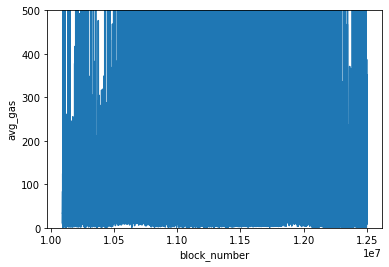

In [22]:

line_Gasavg = sns.lineplot(x="block_number", y="avg_gas", data=dfFinal)
line_Gasavg.set_ylim(bottom=0, top=1000)

In [24]:
dfFinal["avg_gas"].describe

<bound method NDFrame.describe of 0          34.401466
1          38.025468
2          66.245960
3          23.723614
4          41.613122
             ...    
2345138    53.583429
2345139    41.715752
2345140    50.266184
2345141    46.356423
2345142    81.161562
Name: avg_gas, Length: 2345143, dtype: float64>

In [ ]:
sns.histplot(data=dfFinal, x="avg_gas")

In [6]:
# moving avg over 5 blocks
dfFinal['AttackCount_10k'] = dfFinal['AttackCount'].rolling(window=10000,min_periods=1).sum()

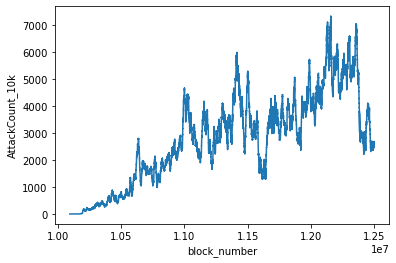

In [6]:
line_attacks10k = sns.lineplot(x="block_number", y="AttackCount_10k", data=dfFinal)
#line_attacks10k.set_ylim(bottom=0, top=1000)

# Regression

In [471]:
#X = dfMaster[['GasFee_Gwei', 'AttackCount', 'transaction_count','difficulty','price_USD_MA30min', 'price_USD' ]]
X = dfFinal[['AttackCount','GasFee_Gwei' ,'transaction_count']]
X['GasFee_Gwei'] = X['GasFee_Gwei'].astype(np.float64)

/var/folders/fw/z98v802x6fx6hbz_spqj2r740000gn/T/ipykernel_6496/272746043.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['GasFee_Gwei'] = X['GasFee_Gwei'].astype(np.float64)


In [472]:
Y = dfFinal['avg_gas']

In [473]:
X = sm.add_constant(X) # adding a constant

In [474]:
X.isna().sum()


const                0
AttackCount          0
GasFee_Gwei          0
transaction_count    0
dtype: int64

In [480]:
X['GasFee_Gwei'].head(2)


6190838821.688442

In [476]:
X.head(2)

,const,AttackCount,GasFee_Gwei,transaction_count
0,1.0,0.0,0.0,92
1,1.0,0.0,0.0,59


In [477]:
Y.head(2)

0    34.401466
1    38.025468
Name: avg_gas, dtype: float64

In [478]:
model = sm.OLS(Y, X).fit()
#predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                avg_gas   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     70.98
Date:                Sat, 30 Apr 2022   Prob (F-statistic):           6.82e-46
Time:                        17:04:47   Log-Likelihood:            -2.1659e+07
No. Observations:             2345143   AIC:                         4.332e+07
Df Residuals:                 2345139   BIC:                         4.332e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                59.0853      4.93

# Workzone

In [135]:
# Attacks with 0 gas fee made by miners
dfAttackMaster[dfAttackMaster['block_number']==12500185]

,transaction_hash,block_number,transaction_index,log_index,from_address,to_address,trans_fromAddress,trans_toAddress,poolId,tf_tokenAddress,tokenName,value,trans_gasPrice,gasUsed,effective_gas_price,trans_gasPrice_Gwei,value_float,Count_1,Count_nHash,within_transaction_order,attack_Id,BatchNr,Attack_UID,GasFee_Gwei
1310334,0xf0bb86f4cc2138495176a04ac436a443b41a7c2a6edea6d324afcdf788afba2f,12500185,0,1,0x26b9f807b1bc99fbf9bc944e73caf93a4ee22a46,0x3a1e1152f51e95c9a3414c434f5126bdf031f3a4,0x5aa17fc7f2950eca85376c3a8cb1509e8e4b39df,0x3a1e1152f51e95c9a3414c434f5126bdf031f3a4,0x26b9f807b1bc99fbf9bc944e73caf93a4ee22a46,0x927d075f9de9817083f0a2123ff22c7856d8540d,None,79239788,0,106654,0,0.0,7.923979e-11,2.0,2.0,2,1973,25,655164,0.0
1310335,0xee04c348d755469384e7ce23146c8e7964ebc5a0036a536304def339fef90ce5,12500185,2,9,0x3a1e1152f51e95c9a3414c434f5126bdf031f3a4,0x26b9f807b1bc99fbf9bc944e73caf93a4ee22a46,0x5aa17fc7f2950eca85376c3a8cb1509e8e4b39df,0x3a1e1152f51e95c9a3414c434f5126bdf031f3a4,0x26b9f807b1bc99fbf9bc944e73caf93a4ee22a46,0x927d075f9de9817083f0a2123ff22c7856d8540d,None,79239788,0,84219,0,0.0,7.923979e-11,2.0,2.0,1,1973,25,655164,0.0


In [108]:
dfTest = pd.read_csv('/Volumes/Extreme SSD/ETH/ETHUSD.csv', header = None, names = ['ts', 'price_USD', 'volume_ETh'])

In [112]:
dfTest['ts'] = pd.to_datetime(dfTest['ts'],unit='s')


In [113]:
dfTest

,ts,price_USD,volume_ETh
0,2022-01-01 00:00:02,3675.95,0.004828
1,2022-01-01 00:00:12,3677.90,0.004828
2,2022-01-01 00:00:22,3682.22,0.004828
3,2022-01-01 00:00:22,3682.94,2.058271
4,2022-01-01 00:00:32,3682.97,0.004828
...,...,...,...
2265314,2022-03-31 23:57:08,3281.06,0.084015
2265315,2022-03-31 23:59:00,3279.01,0.150000
2265316,2022-03-31 23:59:01,3279.01,0.061294
2265317,2022-03-31 23:59:11,3282.59,0.170590


In [ ]:
#dfMaster= dfMaster.drop(['GasFee_Gwei_x','GasFee_Gwei_y'], axis =1)